In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import pandas as pd
import pathlib
from scipy import stats, optimize
from scipy.optimize import nnls

from tyssue.generation import generate_ring
from tyssue.draw.plt_draw import quick_edge_draw
from tyssue.solvers.sheet_vertex_solver import Solver
from tyssue.config.draw import sheet_spec
from tyssue.draw.plt_draw import sheet_view
from tyssue.io.hdf5 import save_datasets

from tyssue.dynamics.planar_gradients import area_grad
from tyssue_taylor.adjusters.adjust_annular import (prepare_tensions, adjust_tensions,
                                                    adjust_areas, adjust_scale, adjust_parameters)
from tyssue_taylor.models.annular import AnnularGeometry as geom
from tyssue_taylor.models.annular import model, lumen_area_grad
from tyssue_taylor.adjusters.cost_functions import _distance
from tyssue_taylor.segmentation.segment2D import generate_ring_from_image, normalize_scale
from tyssue_taylor.adjusters.force_inference import infer_forces, _coef_matrix, _right_side
from tyssue_taylor.models.display import (create_organo, print_tensions, rendering_results,
                                          rendering_convergence_results,
                                          plot_force_inference)

Error: IPOPT shared library failed to import


Using TensorFlow backend.


In [2]:
def create_organo(nb_cells, r_in, r_out, seed=None, rot=None, geom=geom):
    organo = generate_ring(nb_cells, r_in, r_out)
    Nf = organo.Nf
    geom.update_all(organo)
    alpha = 1 + 1/(20*(organo.settings['R_out']-organo.settings['R_in']))
    specs = {
        'face': {
            'is_alive': 1,
            'prefered_area': organo.face_df.area,
            'area_elasticity': 1., },
        'edge': {
            'ux': 0.,
            'uy': 0.,
            'uz': 0.,
            'line_tension': 0.1,
            'is_active': 1
            },
        'vert': {
            'adhesion_strength': 0.,
            'x_ecm': 0.,
            'y_ecm': 0.,
            'is_active': 1
            },
        'settings': {
            'lumen_elasticity': 0.1,
            'lumen_prefered_vol': organo.settings['lumen_volume'],
            'lumen_volume': organo.settings['lumen_volume']
            }
        }
    organo.update_specs(specs, reset=True)
    normalize_scale(organo, geom, refer='edges')
    geom.update_all(organo)
    if seed is not None:
        symetric_tensions = set_init_point(organo.settings['R_in'],
                                           organo.settings['R_out'],
                                           organo.Nf, alpha)
        sin_mul = 1+(np.sin(np.linspace(0, 2*np.pi, organo.Nf,
                                        endpoint=False)))**2
        organo.face_df.prefered_area *= np.random.normal(1.0, 0.05, organo.Nf)
        organo.edge_df.line_tension = prepare_tensions(organo,
                                                       symetric_tensions)
        organo.edge_df.loc[:Nf-1, 'line_tension'] *= sin_mul*np.random.normal(
            1.0, 0.05, organo.Nf)
        geom.update_all(organo)
    if rot is not None:
        organo.vert_df.loc[:, 'x'] = (organo.vert_df.x.copy() * np.cos(rot) -
                                      organo.vert_df.y.copy() * np.sin(rot))
        print('rotated x',
              organo.vert_df.x.copy() * np.cos(rot) -
              organo.vert_df.y.copy() * np.sin(rot))
        organo.vert_df.loc[:, 'y'] = (organo.vert_df.x.copy() * np.sin(rot) +
                                      organo.vert_df.y.copy() * np.cos(rot))
        print('rotated y',
              organo.vert_df.x.copy() * np.sin(rot) +
              organo.vert_df.y.copy() * np.cos(rot))
        geom.update_all(organo)
    organo.vert_df[['x_ecm', 'y_ecm']] = organo.vert_df[['x', 'y']]
    organo.vert_df.loc[organo.basal_verts, 'adhesion_strength'] = 0.01
    new_tensions = organo.edge_df.line_tension
    organo.edge_df.loc[:, 'line_tension'] = new_tensions
    return organo

Reseting datasets values with new specs


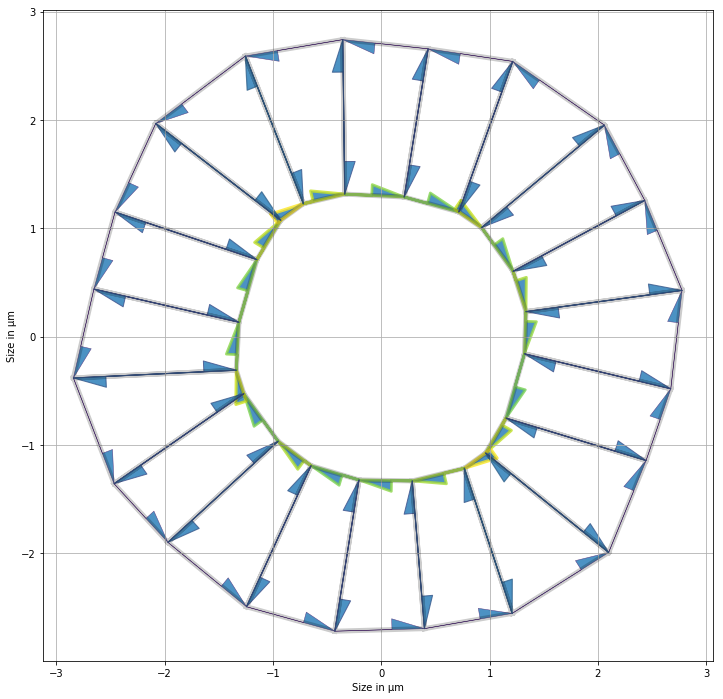

In [3]:
nf, r_in, r_out = (20, 1, 2)
seed = 1
organo3 = create_organo(nf, r_in, r_out)

organo3.edge_df.loc[organo3.apical_edges, 'line_tension'] = [
    0.101, 0.115, 0.126, 0.110, 0.105,
    0.102, 0.112, 0.102, 0.118, 0.105,
    0.104, 0.115, 0.127, 0.116, 0.106,
    0.103, 0.117, 0.105, 0.111, 0.107
]

organo3.edge_df.loc[organo3.basal_edges, 'line_tension'] = [
    0.01, 0.011, 0.012, 0.011, 0.01,
    0.01, 0.011, 0.01, 0.011, 0.01,
    0.01, 0.011, 0.012, 0.011, 0.01,
    0.01, 0.011, 0.01, 0.011, 0.01
]

organo3.edge_df.loc[organo3.lateral_edges, 'line_tension'] = np.array([
    0.03, 0.035, 0.04, 0.035, 0.03,
    0.03, 0.035, 0.03, 0.035, 0.03,
    0.03, 0.035, 0.04, 0.035, 0.03,
    0.03, 0.035, 0.03, 0.035, 0.03,
    0.03, 0.035, 0.04, 0.035, 0.03,
    0.03, 0.035, 0.03, 0.035, 0.03,
    0.03, 0.035, 0.04, 0.035, 0.03,
    0.03, 0.035, 0.03, 0.035, 0.03
])

organo3.face_df.loc[:, 'prefered_area'] = np.array([
    0.08, 0.07, 0.08, 0.09, 0.09,
    0.10, 0.09, 0.08, 0.09, 0.09,
    0.10, 0.11, 0.10, 0.11, 0.12,
    0.11, 0.10, 0.09, 0.08, 0.09
]) + organo3.face_df.area

geom.update_all(organo3)
Solver.find_energy_min(organo3, geom, model)
print_tensions(organo3, organo3)

In [4]:
real_data = np.concatenate((organo3.edge_df.line_tension[:3*organo3.Nf],
                            organo3.face_df.prefered_area - organo3.face_df.area,
                            [organo3.settings['lumen_prefered_vol']-
                             organo3.settings['lumen_volume']]))
print(organo3.edge_df.line_tension, '\n',
      organo3.face_df.prefered_area - organo3.face_df.area)

edge
0     0.101
1     0.115
2     0.126
3     0.110
4     0.105
5     0.102
6     0.112
7     0.102
8     0.118
9     0.105
10    0.104
11    0.115
12    0.127
13    0.116
14    0.106
15    0.103
16    0.117
17    0.105
18    0.111
19    0.107
20    0.010
21    0.011
22    0.012
23    0.011
24    0.010
25    0.010
26    0.011
27    0.010
28    0.011
29    0.010
      ...  
50    0.030
51    0.035
52    0.040
53    0.035
54    0.030
55    0.030
56    0.035
57    0.030
58    0.035
59    0.030
60    0.030
61    0.035
62    0.040
63    0.035
64    0.030
65    0.030
66    0.035
67    0.030
68    0.035
69    0.030
70    0.030
71    0.035
72    0.040
73    0.035
74    0.030
75    0.030
76    0.035
77    0.030
78    0.035
79    0.030
Name: line_tension, Length: 80, dtype: float64 
 face
0     0.037466
1     0.042980
2     0.047452
3     0.041083
4     0.039120
5     0.037130
6     0.042399
7     0.037119
8     0.043188
9     0.038093
10    0.038654
11    0.042510
12    0.047137
13    0.042130

Computing the rank of $A$, we can see that the linear equations system has infinitely many solutions

In [5]:
print('Rank of A: ',
      np.linalg.matrix_rank(_coef_matrix(organo3, sup_param='areas')),
      '\nDimension of A: ',
      _coef_matrix(organo3, sup_param='areas').shape[0])

Rank of A:  78 
Dimension of A:  81


## Matrice sans modification

Apical tensions:  [0.04228063 0.04209476 0.04214343 0.04178162 0.04229147 0.04228551
 0.04247959 0.04221032 0.04321564 0.04274087 0.04241868 0.0421895
 0.04238066 0.04239681 0.04273737 0.04281279 0.04319247 0.04228582
 0.04259294 0.04279708] 
Basal tensions:  [7.56366247e-04 0.00000000e+00 0.00000000e+00 1.06661700e-04
 2.04612453e-04 8.80746300e-06 0.00000000e+00 4.16552239e-04
 0.00000000e+00 1.14210349e-04 6.90227856e-04 0.00000000e+00
 0.00000000e+00 0.00000000e+00 6.36313255e-04 5.08326831e-04
 0.00000000e+00 1.02627247e-04 0.00000000e+00 0.00000000e+00] 
Lateral tensions:  [0.00606531 0.00615937 0.00973045 0.00887515 0.00629512 0.0066392
 0.00826032 0.00744875 0.00764812 0.00864104 0.00572875 0.00646742
 0.00923489 0.00937256 0.00675324 0.00559535 0.007989   0.00831346
 0.00757601 0.00825848] 
Area elasticity:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] 
Lumen area elasticity:  0.0 
Distance to solution:  0.3771951409387592 
NNLS residuals:  0.04337647345043281

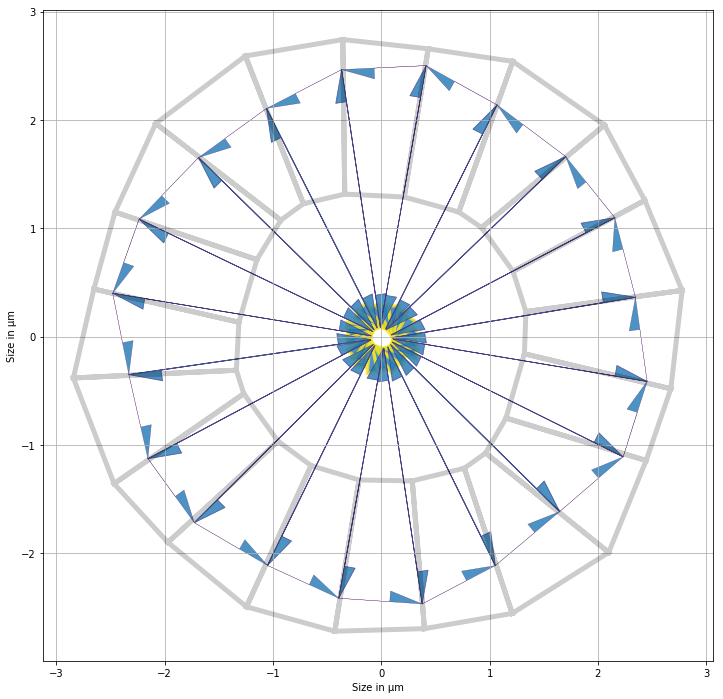

In [6]:
matrix = _coef_matrix(organo3, sup_param='areas')
constant = _right_side(organo3, matrix)
no_mod_mat, residuals = nnls(matrix, constant)
organo3_no_mod_mat = organo3.copy()
organo3_no_mod_mat.edge_df.loc[:, 'line_tension'] = prepare_tensions(organo3_no_mod_mat,
                                                                     no_mod_mat[:3*organo3.Nf])
organo3_no_mod_mat.face_df.loc[:, 'prefered_area'] = organo3_no_mod_mat.face_df.area + no_mod_mat[3*organo3.Nf:
                                                                                                  4*organo3.Nf]
organo3_no_mod_mat.settings['lumen_prefered_vol'] = no_mod_mat[-1]
Solver.find_energy_min(organo3_no_mod_mat, geom, model)
print_tensions(organo3_no_mod_mat, organo3)
print('Apical tensions: ', no_mod_mat[organo3.apical_edges],
      '\nBasal tensions: ', no_mod_mat[organo3.basal_edges],
      '\nLateral tensions: ', no_mod_mat[organo3.lateral_edges[:organo3.Nf]],
      '\nArea elasticity: ', no_mod_mat[organo3.Nf*3:-1],
      '\nLumen area elasticity: ', no_mod_mat[-1],
      '\nDistance to solution: ', np.linalg.norm(real_data-no_mod_mat),
      '\nNNLS residuals: ', residuals)

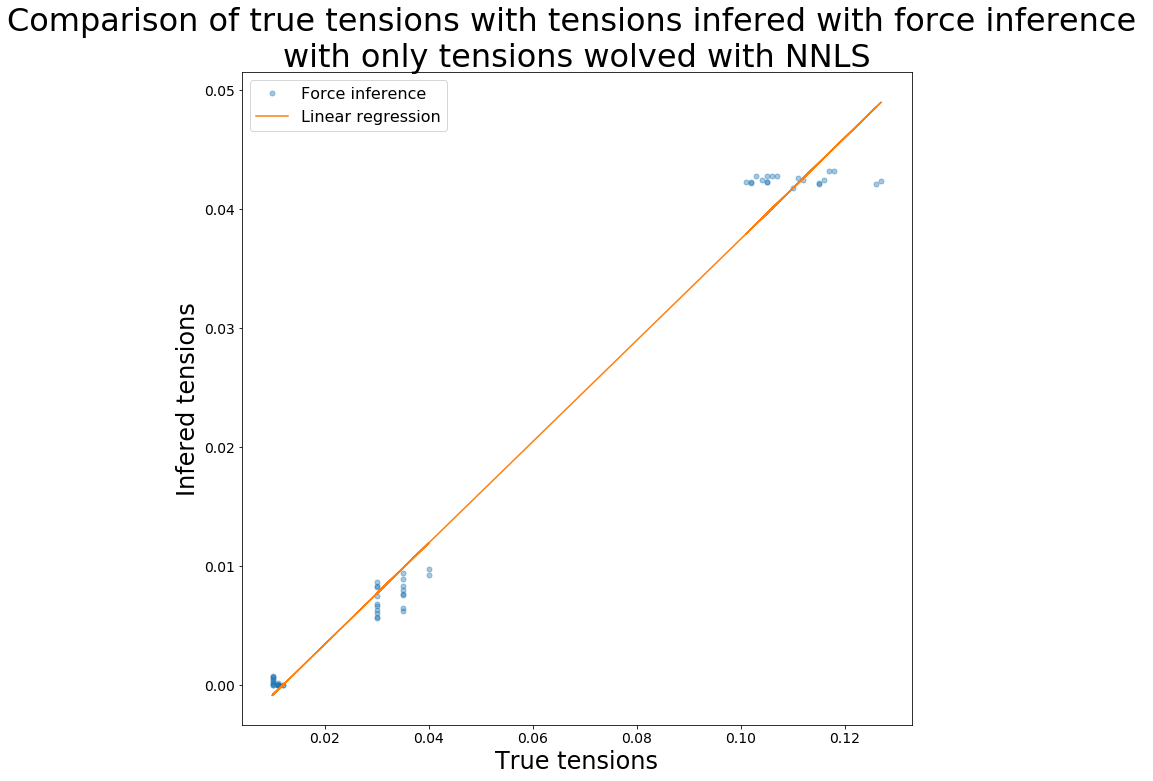

R value : 0.9926516008278262 
Standard error : 0.0019345387839601303


In [7]:
rendering_results(organo3, organo3.edge_df.line_tension[:3*organo3.Nf],
                  no_mod_mat[:3*organo3.Nf],
                  'Comparison of true tensions with tensions infered with force inference \n' +
                  'with only tensions wolved with NNLS',
                  'True tensions', 'Infered tensions', ('Force inference', 'Linear regression'))

## Matrice avec une contrainte sur le rapport des moyennes des tensions

Apical tensions:  [0.03662628 0.03740145 0.03799546 0.03685802 0.03692053 0.0369128
 0.03731153 0.03685189 0.03846444 0.03745836 0.03678049 0.0373555
 0.0381982  0.03770348 0.03724994 0.03731509 0.0383303  0.03705937
 0.03745534 0.03751674] 
Basal tensions:  [1.25385500e-03 0.00000000e+00 0.00000000e+00 2.61149096e-04
 3.67641356e-04 8.43720139e-05 0.00000000e+00 7.35530415e-04
 0.00000000e+00 4.09682833e-04 1.23498051e-03 1.59467093e-06
 0.00000000e+00 0.00000000e+00 1.06259728e-03 9.38346813e-04
 0.00000000e+00 2.76605202e-04 0.00000000e+00 0.00000000e+00] 
Lateral tensions:  [0.01110866 0.0112859  0.0143382  0.01362519 0.01133561 0.01157999
 0.01297572 0.01231294 0.01247231 0.013267   0.01084635 0.01152241
 0.01392685 0.0140356  0.01173685 0.01073519 0.0127196  0.01303239
 0.01242023 0.01296368] 
Area elasticity:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] 
Lumen area elasticity:  0.010086058216483796 
Distance to solution:  0.3894308183519815 
NNLS residuals:  0.

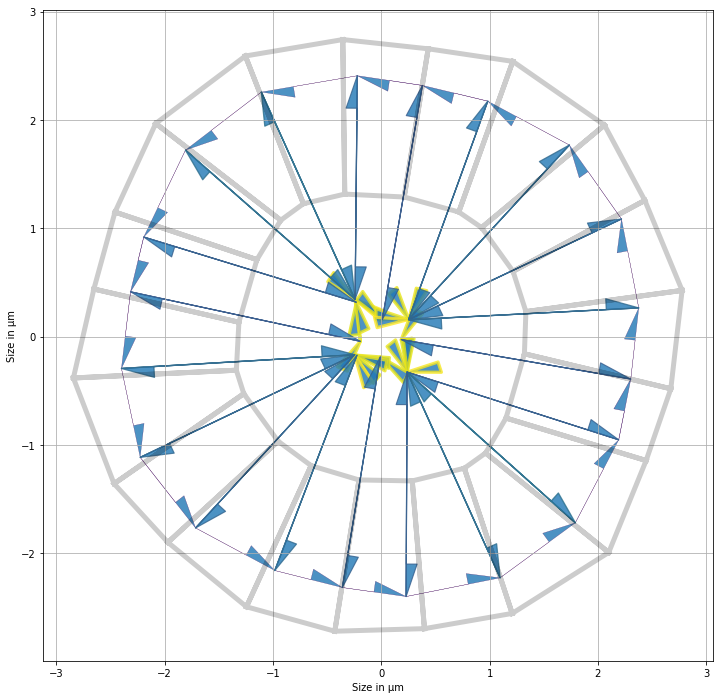

In [8]:
matrix = _coef_matrix(organo3, sup_param='areas')
constant = _right_side(organo3, matrix)
avg_line1 = np.concatenate((np.ones(organo3.Nf),
                            np.zeros(organo3.Nf),
                            -3*np.ones(organo3.Nf),
                            np.zeros(organo3.Nf+1)))
avg_cste = [0]
matrix = np.vstack((matrix, avg_line1))
constant = np.concatenate((constant, avg_cste))
mat_mean_cst, residuals = nnls(matrix, constant)
organo3_mean_cst = organo3.copy()
organo3_mean_cst.edge_df.loc[:, 'line_tension'] = prepare_tensions(organo3_mean_cst,
                                                                   mat_mean_cst[:3*organo3.Nf])
organo3_mean_cst.face_df.loc[:, 'prefered_area'] = organo3_mean_cst.face_df.area + mat_mean_cst[3*organo3.Nf:
                                                                                              4*organo3.Nf]
organo3_mean_cst.settings['lumen_prefered_vol'] = mat_mean_cst[-1]
Solver.find_energy_min(organo3_mean_cst, geom, model)
print_tensions(organo3_mean_cst, organo3)
print('Apical tensions: ', mat_mean_cst[organo3.apical_edges],
      '\nBasal tensions: ', mat_mean_cst[organo3.basal_edges],
      '\nLateral tensions: ', mat_mean_cst[organo3.lateral_edges[:organo3.Nf]],
      '\nArea elasticity: ', mat_mean_cst[organo3.Nf*3:-1],
      '\nLumen area elasticity: ', mat_mean_cst[-1],
      '\nDistance to solution: ', np.linalg.norm(real_data-mat_mean_cst),
      '\nNNLS residuals: ', residuals)

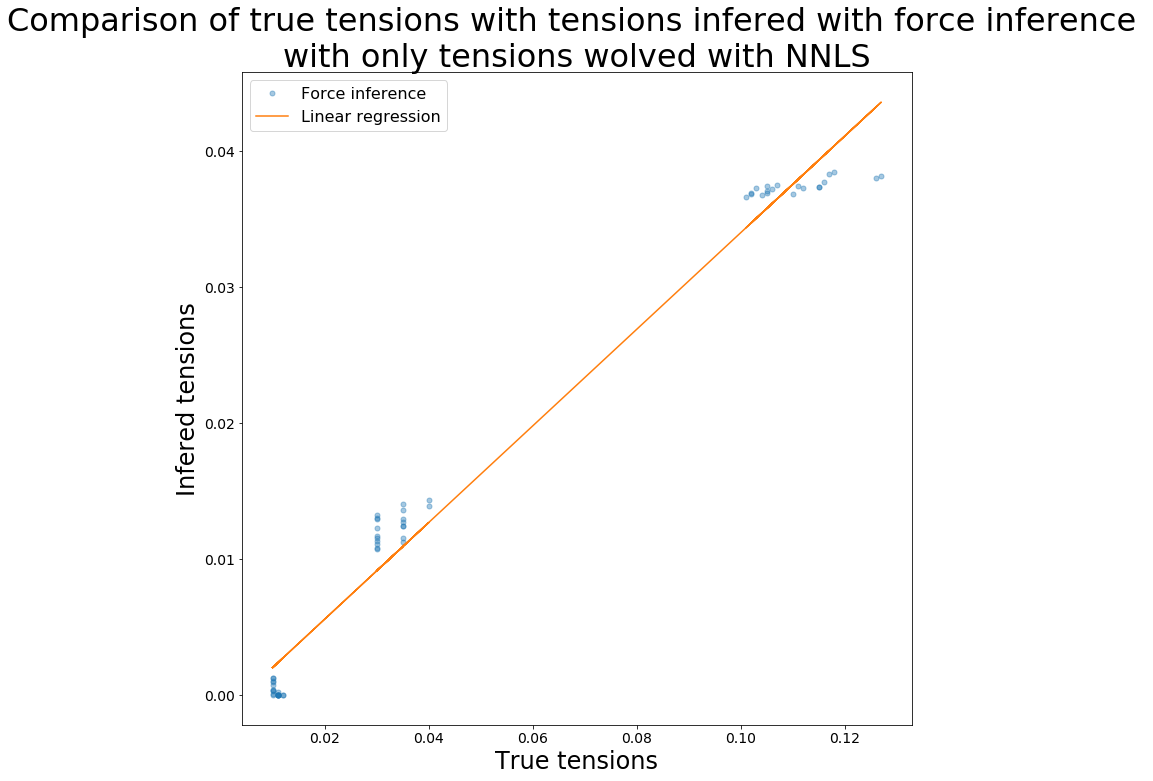

R value : 0.9892976775341998 
Standard error : 0.0019520903625818828


In [9]:
rendering_results(organo3, organo3.edge_df.line_tension[:3*organo3.Nf],
                  mat_mean_cst[:3*organo3.Nf],
                  'Comparison of true tensions with tensions infered with force inference \n' +
                  'with only tensions wolved with NNLS',
                  'True tensions', 'Infered tensions', ('Force inference', 'Linear regression'))

## Matrice avec la dernière ligne "splitée" en trois contraintes
On supprime la contrainte $$\sum \Lambda_{i,j} = c$$ On ajoute les contraintes $$\Lambda_0 + \Lambda_1 + \Lambda_2 = c_1$$ $$\Lambda_3 + \Lambda_4 + \Lambda_5 = c_2$$ $$\Lambda_6 + \Lambda_7 + \Lambda_8 = c_3$$ Où $c_1+c_2+c_3=c$

Apical tensions:  [0.09826529 0.09968102 0.1009633  0.09844731 0.09890522 0.09891849
 0.09984944 0.09874387 0.10259587 0.10023493 0.09869637 0.09970427
 0.10153551 0.10053101 0.09982441 0.10001742 0.10233802 0.09919897
 0.1001589  0.10037686] 
Basal tensions:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] 
Lateral tensions:  [0.02513449 0.02535963 0.03401955 0.0320109  0.02565249 0.02642363
 0.03022285 0.02831891 0.02902686 0.03130473 0.02429117 0.02612192
 0.03284264 0.03317489 0.02687618 0.02395382 0.02981273 0.03050709
 0.02863693 0.03023515] 
Area elasticity:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] 
Lumen area elasticity:  0.0 
Distance to solution:  0.19886519349048212 
NNLS residuals:  0.13293265464339027


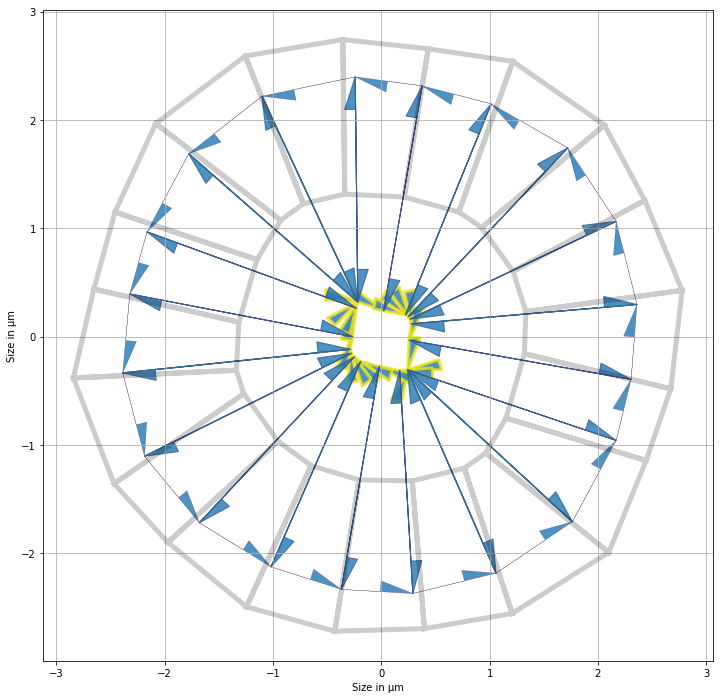

In [10]:
from scipy.optimize import nnls
matrix = _coef_matrix(organo3, sup_param='areas')
constant = _right_side(organo3, matrix)
constant[-1] = organo3.Nf*0.1
constant = np.concatenate((constant, [0, organo3.Nf*0.03]))
matrix = _coef_matrix(organo3, sup_param='areas')
matrix[-1] = np.concatenate((np.ones(organo3.Nf),
                             np.zeros(3*organo3.Nf+1)))
matrix = np.vstack((matrix,
                    np.concatenate((np.zeros(organo3.Nf), np.ones(organo3.Nf), np.zeros(2*organo3.Nf+1))),
                    np.concatenate((np.zeros(2*organo3.Nf), np.ones(organo3.Nf), np.zeros(organo3.Nf+1)))))
mat_3_cst, residuals = nnls(matrix, constant)
organo3_mat_3_cst = organo3.copy()
organo3_mat_3_cst.edge_df.loc[:, 'line_tension'] = prepare_tensions(organo3_mat_3_cst,
                                                                    mat_3_cst[:3*organo3.Nf])
organo3_mat_3_cst.face_df.loc[:, 'prefered_area'] = organo3_mat_3_cst.face_df.area + mat_3_cst[3*organo3.Nf:
                                                                                                4*organo3.Nf]
organo3_mat_3_cst.settings['lumen_prefered_vol'] = mat_3_cst[-1]
Solver.find_energy_min(organo3_mat_3_cst, geom, model)
print_tensions(organo3_mat_3_cst, organo3)
print('Apical tensions: ', mat_3_cst[organo3.apical_edges],
      '\nBasal tensions: ', mat_3_cst[organo3.basal_edges],
      '\nLateral tensions: ', mat_3_cst[organo3.lateral_edges[:organo3.Nf]],
      '\nArea elasticity: ', mat_3_cst[organo3.Nf*3:-1],
      '\nLumen area elasticity: ', mat_3_cst[-1],
      '\nDistance to solution: ', np.linalg.norm(real_data-mat_3_cst),
      '\nNNLS residuals: ', residuals)

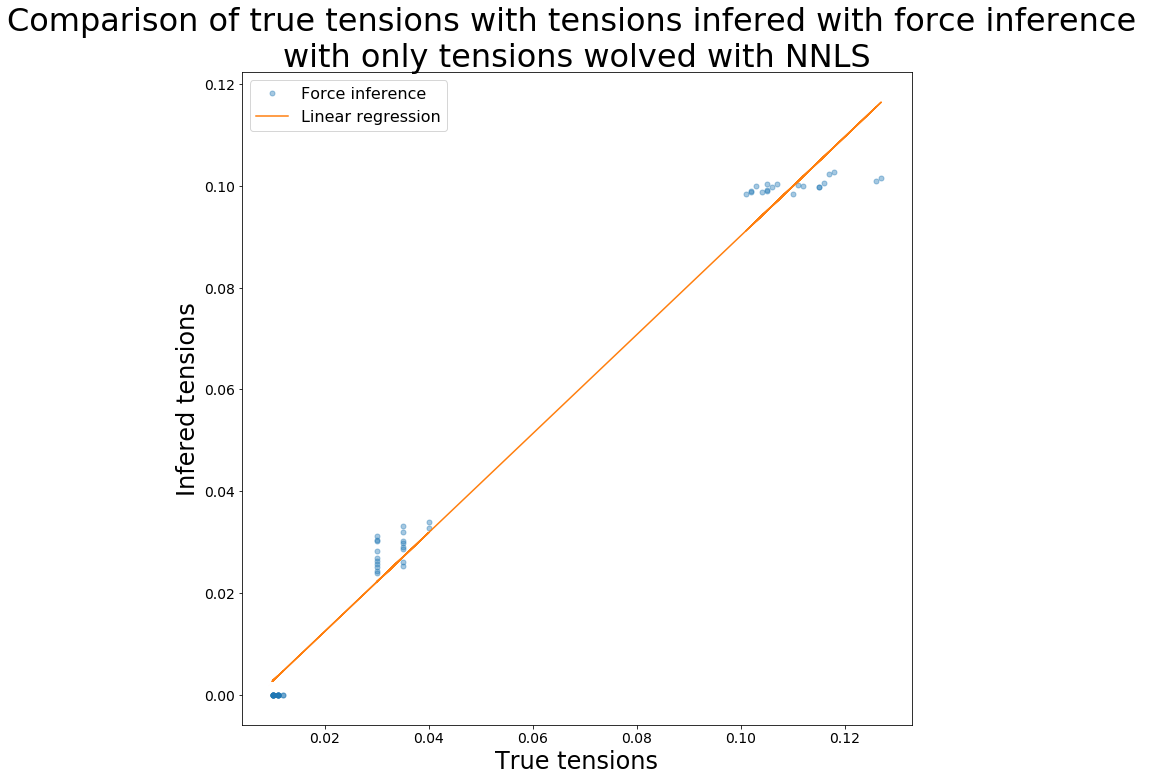

R value : 0.9928826675215922 
Standard error : 0.004338175903902367


In [11]:
rendering_results(organo3, organo3.edge_df.line_tension[:3*organo3.Nf],
                  mat_3_cst[:3*organo3.Nf],
                  'Comparison of true tensions with tensions infered with force inference \n' +
                  'with only tensions wolved with NNLS',
                  'True tensions', 'Infered tensions', ('Force inference', 'Linear regression'))

## Matrice avec la dernière ligne "splitée" en deux contraintes
On constate qu'il suffit d'ajouter deux contraintes pour obtenir le résultat attendu.

Apical tensions:  [0.00030598 0.00029765 0.00028885 0.0002948  0.00030343 0.00030002
 0.00029497 0.00029713 0.00029945 0.00030641 0.00030615 0.00029629
 0.00028937 0.00029576 0.00030668 0.0003053  0.00029526 0.00029359
 0.00029521 0.00030343] 
Basal tensions:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] 
Lateral tensions:  [0.00000000e+00 0.00000000e+00 1.45459555e-05 6.21209950e-06
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 7.41638485e-06 0.00000000e+00 0.00000000e+00
 9.54343842e-06 1.06533575e-05 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 9.32297570e-07] 
Area elasticity:  [3.42356519e-05 3.28457262e-05 3.75048939e-05 3.73548936e-05
 3.62936470e-05 4.03342847e-05 4.54142839e-05 4.16550552e-05
 3.86821466e-05 3.26712731e-05 3.41006306e-05 3.53217382e-05
 3.67818005e-05 3.52665476e-05 3.36434497e-05 3.58659157e-05
 4.34427190e-05 4.37431030e-05 4.39768125e-05 3.76951930e-05] 
Lumen area elasticity:  0

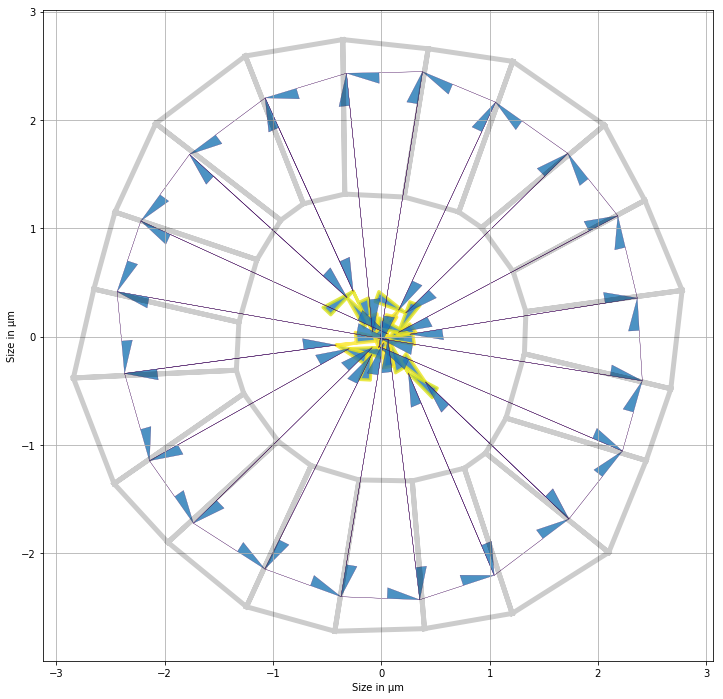

In [12]:
from scipy.optimize import nnls
matrix = _coef_matrix(organo3, sup_param='areas')
constant = _right_side(organo3, matrix)
constant[-1] = 0.006
constant = np.concatenate((constant, [0]))
matrix = _coef_matrix(organo3, sup_param='areas')
matrix[-1] = np.concatenate((np.ones(organo3.Nf),
                             np.zeros(3*organo3.Nf+1)))
matrix = np.vstack((matrix,
                    np.concatenate((np.zeros(2*organo3.Nf), np.ones(organo3.Nf), np.zeros(organo3.Nf+1)))))
mat_2_cst, residuals = nnls(matrix, constant)
organo3_mat_2_cst = organo3.copy()
organo3_mat_2_cst.edge_df.loc[:, 'line_tension'] = prepare_tensions(organo3_mat_2_cst,
                                                                    mat_2_cst[:3*organo3.Nf])
organo3_mat_2_cst.face_df.loc[:, 'prefered_area'] = organo3_mat_2_cst.face_df.area + mat_2_cst[3*organo3.Nf:
                                                                                                4*organo3.Nf]
organo3_mat_2_cst.settings['lumen_prefered_vol'] = mat_2_cst[-1]
Solver.find_energy_min(organo3_mat_2_cst, geom, model)
print_tensions(organo3_mat_2_cst, organo3)
print('Apical tensions: ', mat_2_cst[organo3.apical_edges],
      '\nBasal tensions: ', mat_2_cst[organo3.basal_edges],
      '\nLateral tensions: ', mat_2_cst[organo3.lateral_edges[:organo3.Nf]],
      '\nArea elasticity: ', mat_2_cst[organo3.Nf*3:-1],
      '\nLumen area elasticity: ', mat_2_cst[-1],
      '\nDistance to solution: ', np.linalg.norm(real_data-mat_2_cst),
      '\nNNLS residuals: ', residuals)

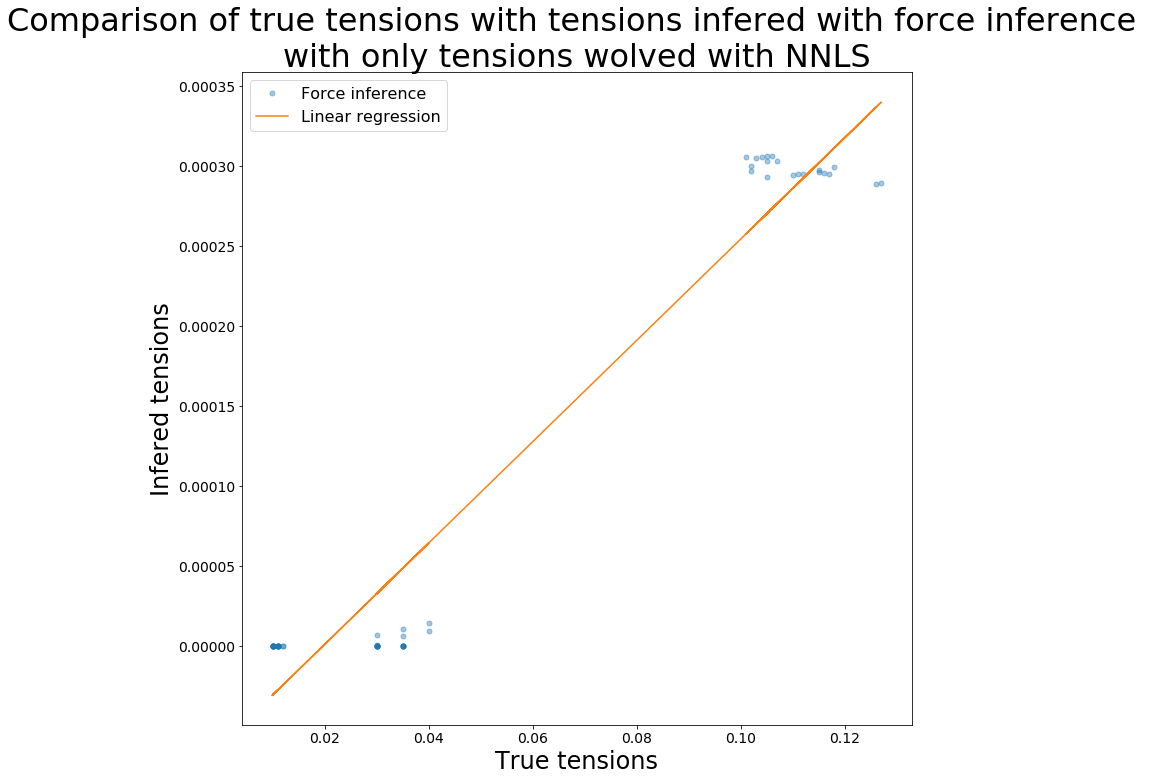

R value : 0.9706617684130284 
Standard error : 2.9221671683898836e-05


In [13]:
rendering_results(organo3, organo3.edge_df.line_tension[:3*organo3.Nf],
                  mat_2_cst[:3*organo3.Nf],
                  'Comparison of true tensions with tensions infered with force inference \n' +
                  'with only tensions wolved with NNLS',
                  'True tensions', 'Infered tensions', ('Force inference', 'Linear regression'))

## Matrice avec deux contraintes d'égalité
Ici on pose les contraintes $\Lambda_1 = \Lambda_2$ et $\Lambda_6 = \Lambda_7$

Apical tensions:  [0.04230204 0.04211692 0.04214178 0.04178221 0.04229383 0.04228931
 0.04248464 0.04221636 0.04322273 0.04274868 0.04242717 0.04219869
 0.0423907  0.04240775 0.04274938 0.04282594 0.04320712 0.04230187
 0.04261119 0.04281803] 
Basal tensions:  [5.03868186e-04 0.00000000e+00 0.00000000e+00 1.07086929e-04
 2.05107539e-04 9.12874808e-06 0.00000000e+00 4.16655410e-04
 0.00000000e+00 1.14281790e-04 6.90392090e-04 0.00000000e+00
 0.00000000e+00 0.00000000e+00 6.36340452e-04 5.08291177e-04
 0.00000000e+00 1.02540571e-04 0.00000000e+00 0.00000000e+00] 
Lateral tensions:  [0.00608024 0.00615762 0.00973209 0.00887509 0.00629544 0.00663974
 0.00826127 0.00744978 0.0076494  0.00864253 0.00572984 0.0064688
 0.009237   0.00937481 0.00675497 0.00559692 0.00799155 0.00831622
 0.00757891 0.00826203] 
Area elasticity:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] 
Lumen area elasticity:  0.0 
Distance to solution:  0.3771616076840694 
NNLS residuals:  0.0433808802102481

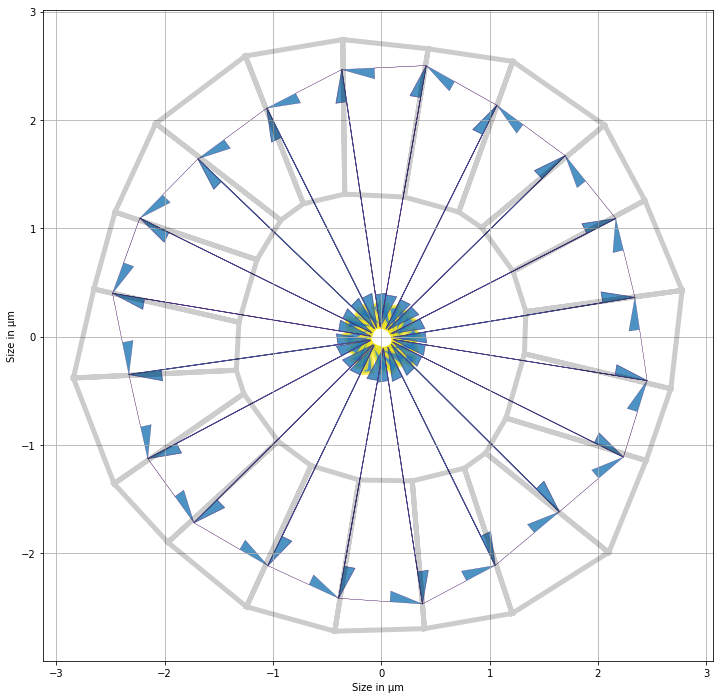

In [14]:
from scipy.optimize import nnls
matrix = _coef_matrix(organo3, sup_param='areas')
constant = _right_side(organo3, matrix)
constant = np.concatenate((constant, [0, 0]))
matrix = np.vstack((matrix,
                    np.concatenate(([0, 1, -1], np.zeros(4*organo3.Nf-2))),
                    np.concatenate((np.zeros(organo3.Nf), [1, -1], np.zeros(3*organo3.Nf-1)))))
mat_eq_cst, residuals = nnls(matrix, constant)
organo3_eq_cst = organo3.copy()
organo3_eq_cst.edge_df.loc[:, 'line_tension'] = prepare_tensions(organo3_eq_cst,
                                                                 mat_eq_cst[:3*organo3.Nf])
organo3_eq_cst.face_df.loc[:, 'prefered_area'] = organo3_eq_cst.face_df.area + mat_eq_cst[3*organo3.Nf:
                                                                                          4*organo3.Nf]
organo3_eq_cst.settings['lumen_prefered_vol'] = mat_eq_cst[-1]
Solver.find_energy_min(organo3_eq_cst, geom, model)
print_tensions(organo3_eq_cst, organo3)
print('Apical tensions: ', mat_eq_cst[organo3.apical_edges],
      '\nBasal tensions: ', mat_eq_cst[organo3.basal_edges],
      '\nLateral tensions: ', mat_eq_cst[organo3.lateral_edges[:organo3.Nf]],
      '\nArea elasticity: ', mat_eq_cst[organo3.Nf*3:-1],
      '\nLumen area elasticity: ', mat_eq_cst[-1],
      '\nDistance to solution: ', np.linalg.norm(real_data-mat_eq_cst),
      '\nNNLS residuals: ', residuals)

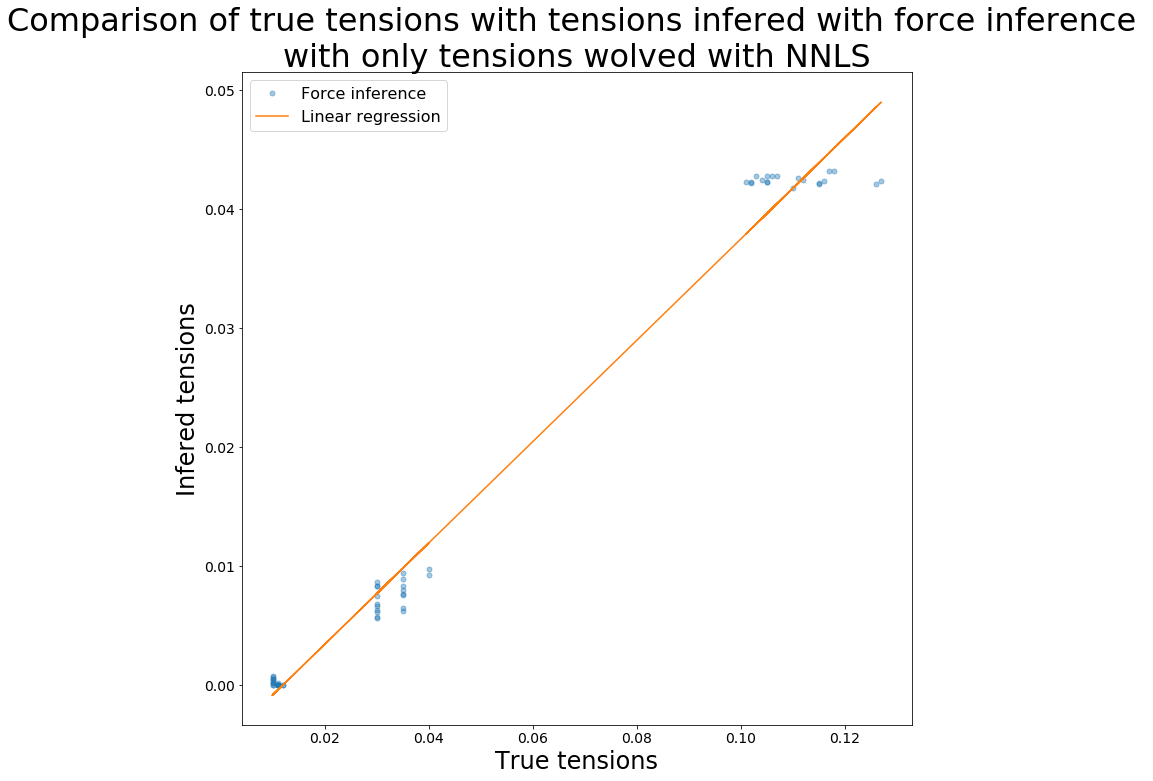

R value : 0.9926689853897473 
Standard error : 0.001933109871929669


In [15]:
rendering_results(organo3, organo3.edge_df.line_tension[:3*organo3.Nf],
                  mat_eq_cst[:3*organo3.Nf],
                  'Comparison of true tensions with tensions infered with force inference \n' +
                  'with only tensions wolved with NNLS',
                  'True tensions', 'Infered tensions', ('Force inference', 'Linear regression'))

## Matrice avec cst somme des élasticité = 0

Apical tensions:  [0.00037833 0.00037667 0.00037711 0.00037387 0.00037843 0.00037838
 0.00038011 0.0003777  0.0003867  0.00038245 0.00037957 0.00037752
 0.00037923 0.00037937 0.00038242 0.00038309 0.00038649 0.00037838
 0.00038113 0.00038295] 
Basal tensions:  [6.76807297e-06 0.00000000e+00 0.00000000e+00 9.54424095e-07
 1.83090139e-06 7.88104342e-08 0.00000000e+00 3.72736880e-06
 0.00000000e+00 1.02197048e-06 6.17625722e-06 0.00000000e+00
 0.00000000e+00 0.00000000e+00 5.69382169e-06 4.54858093e-06
 0.00000000e+00 9.18323236e-07 0.00000000e+00 0.00000000e+00] 
Lateral tensions:  [5.42732160e-05 5.51148848e-05 8.70694797e-05 7.94161029e-05
 5.63296055e-05 5.94085095e-05 7.39144888e-05 6.66524885e-05
 6.84364423e-05 7.73212596e-05 5.12616997e-05 5.78714306e-05
 8.26351300e-05 8.38669600e-05 6.04289409e-05 5.00680235e-05
 7.14867321e-05 7.43899965e-05 6.77912040e-05 7.38980983e-05] 
Area elasticity:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] 
Lumen area elasticity:  0

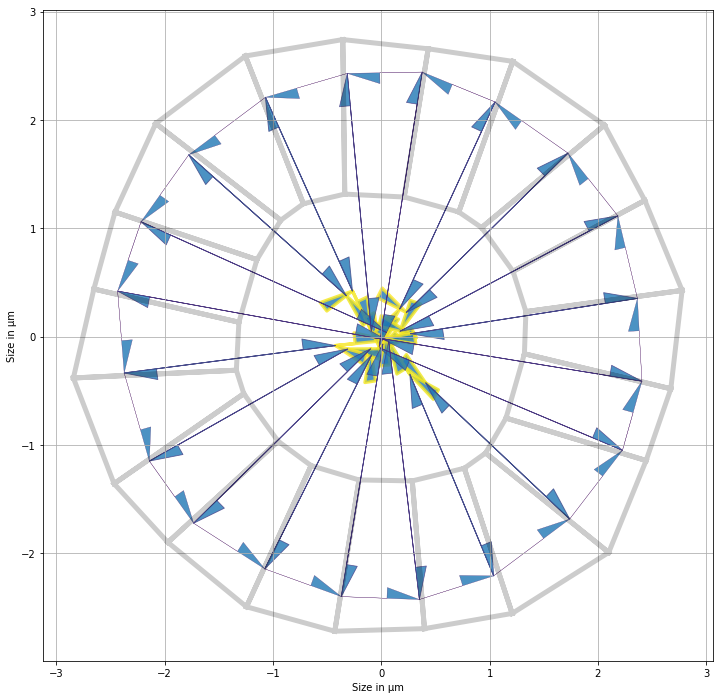

In [16]:
matrix = _coef_matrix(organo3, sup_param='areas')
constant = _right_side(organo3, matrix)
constant[-1] = 0.009
constant = np.concatenate((constant, [0]))
matrix = np.vstack((matrix,
                    np.concatenate((np.zeros(3*organo3.Nf), np.ones(organo3.Nf+1)))))
mat_eq_cst, residuals = nnls(matrix, constant)
organo3_eq_cst = organo3.copy()
organo3_eq_cst.edge_df.loc[:, 'line_tension'] = prepare_tensions(organo3_eq_cst,
                                                                 mat_eq_cst[:3*organo3.Nf])
organo3_eq_cst.face_df.loc[:, 'prefered_area'] = organo3_eq_cst.face_df.area + mat_eq_cst[3*organo3.Nf:
                                                                                          4*organo3.Nf]
organo3_eq_cst.settings['lumen_prefered_vol'] = mat_eq_cst[-1]
Solver.find_energy_min(organo3_eq_cst, geom, model)
print_tensions(organo3_eq_cst, organo3)
print('Apical tensions: ', mat_eq_cst[organo3.apical_edges],
      '\nBasal tensions: ', mat_eq_cst[organo3.basal_edges],
      '\nLateral tensions: ', mat_eq_cst[organo3.lateral_edges[:organo3.Nf]],
      '\nArea elasticity: ', mat_eq_cst[organo3.Nf*3:-1],
      '\nLumen area elasticity: ', mat_eq_cst[-1],
      '\nDistance to solution: ', np.linalg.norm(real_data-mat_eq_cst),
      '\nNNLS residuals: ', residuals)

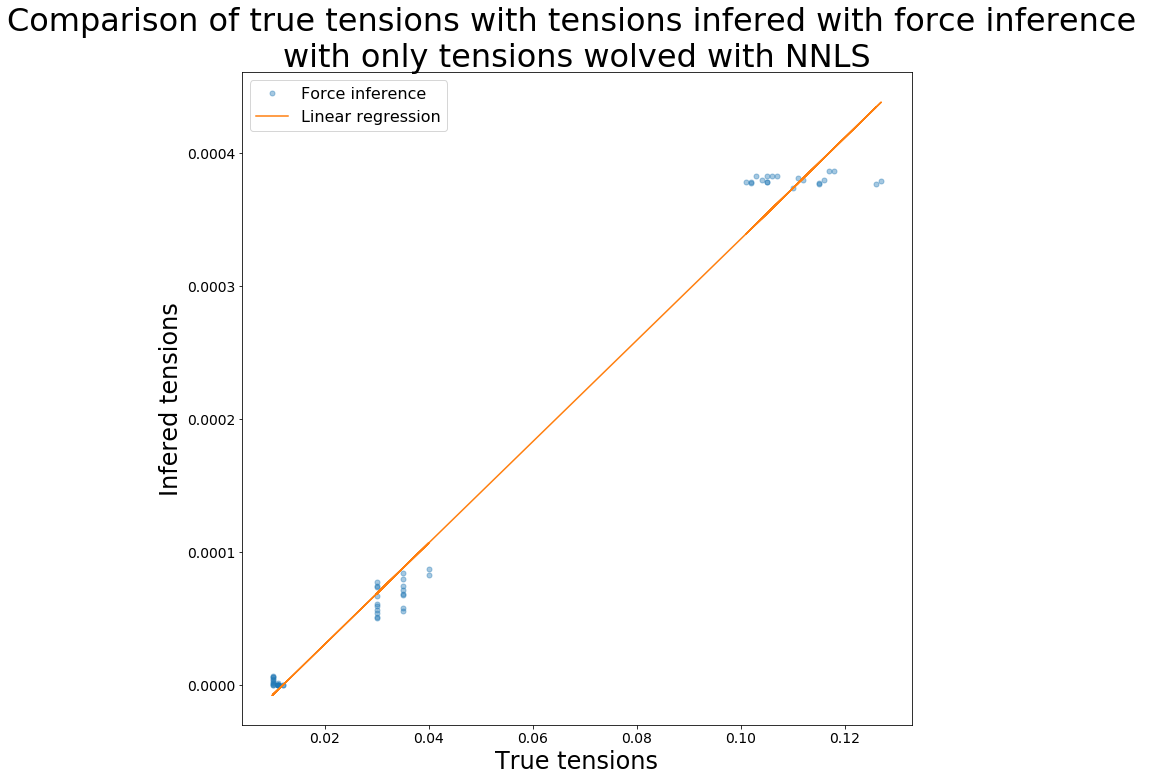

R value : 0.9926516008278261 
Standard error : 1.7310528740442876e-05


In [17]:
rendering_results(organo3, organo3.edge_df.line_tension[:3*organo3.Nf],
                  mat_eq_cst[:3*organo3.Nf],
                  'Comparison of true tensions with tensions infered with force inference \n' +
                  'with only tensions wolved with NNLS',
                  'True tensions', 'Infered tensions', ('Force inference', 'Linear regression'))

## Matrice avec somme des tensions constantes dans chaque cellule

Apical tensions:  [0.         0.00399373 0.00920097 0.00305123 0.         0.0038671
 0.00152413 0.00219724 0.0065136  0.00317757 0.         0.00499183
 0.01002564 0.00642022 0.         0.00160231 0.00614762 0.00320512
 0.0025162  0.00306652] 
Basal tensions:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] 
Lateral tensions:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] 
Area elasticity:  [0.08993011 0.08349154 0.07663969 0.08433176 0.0883898  0.08348395
 0.08638566 0.08552519 0.08034742 0.08483311 0.09027601 0.0824593
 0.07573743 0.0803105  0.08892236 0.08638113 0.08068549 0.08424785
 0.08528644 0.08499356] 
Lumen area elasticity:  0.411851818354457 
Distance to solution:  0.66779790393237 
NNLS residuals:  0.43164057777917847


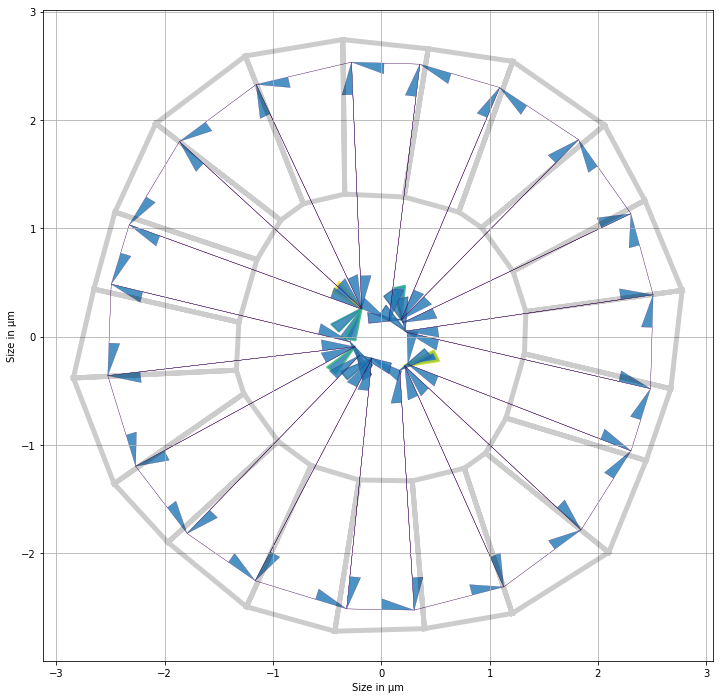

In [18]:
matrix = _coef_matrix(organo3, sup_param='areas')
constant = _right_side(organo3, matrix)
constant[-1] = 0.009
avg_cste = [0.15]*organo3.Nf
for i in range(organo3.Nf):
    i_cell_line = np.zeros(4*organo3.Nf+1)
    index = np.squeeze(np.argwhere(organo3.edge_df.face.values == i))
    i_cell_line[index] = 1
    matrix = np.vstack((matrix, i_cell_line))
constant = np.concatenate((constant, avg_cste))
mat_eq_cst, residuals = nnls(matrix, constant)
organo3_eq_cst = organo3.copy()
organo3_eq_cst.edge_df.loc[:, 'line_tension'] = prepare_tensions(organo3_eq_cst,
                                                                 mat_eq_cst[:3*organo3.Nf])
organo3_eq_cst.face_df.loc[:, 'prefered_area'] = organo3_eq_cst.face_df.area + mat_eq_cst[3*organo3.Nf:
                                                                                          4*organo3.Nf]
organo3_eq_cst.settings['lumen_prefered_vol'] = mat_eq_cst[-1]
Solver.find_energy_min(organo3_eq_cst, geom, model)
print_tensions(organo3_eq_cst, organo3)
print('Apical tensions: ', mat_eq_cst[organo3.apical_edges],
      '\nBasal tensions: ', mat_eq_cst[organo3.basal_edges],
      '\nLateral tensions: ', mat_eq_cst[organo3.lateral_edges[:organo3.Nf]],
      '\nArea elasticity: ', mat_eq_cst[organo3.Nf*3:-1],
      '\nLumen area elasticity: ', mat_eq_cst[-1],
      '\nDistance to solution: ', np.linalg.norm(real_data-mat_eq_cst),
      '\nNNLS residuals: ', residuals)

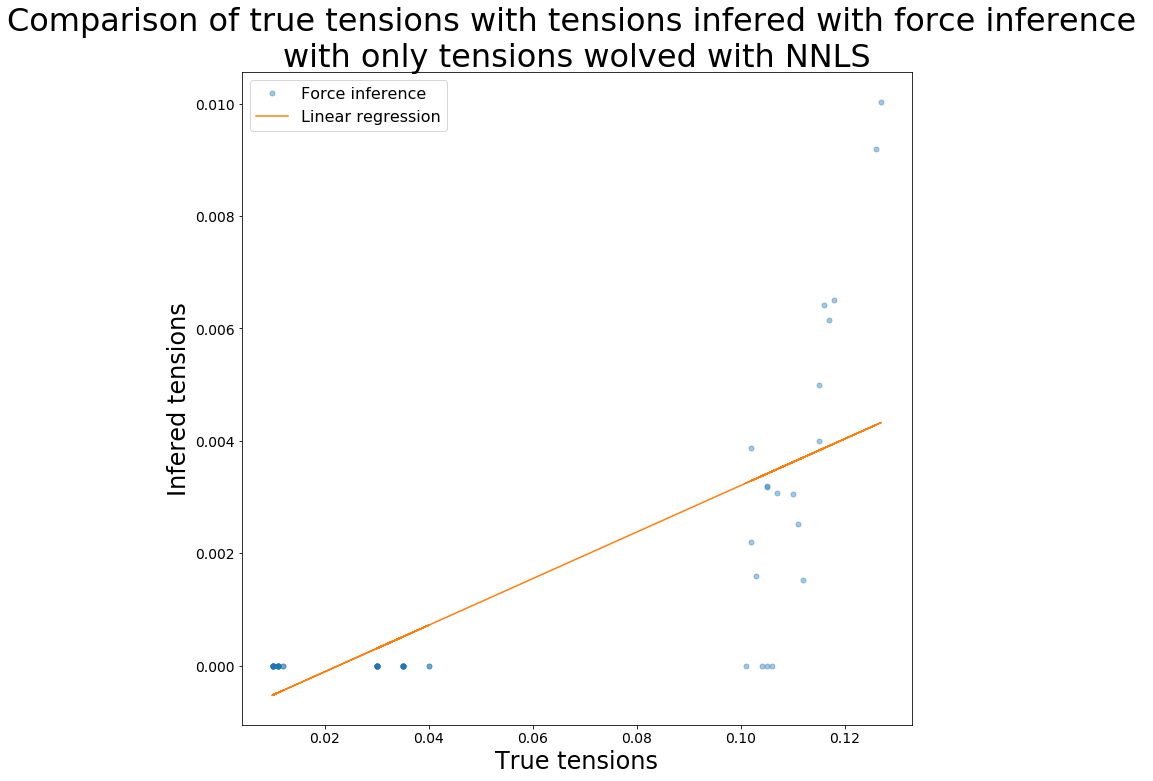

R value : 0.7570507084366376 
Standard error : 0.0013317085188314455


In [19]:
rendering_results(organo3, organo3.edge_df.line_tension[:3*organo3.Nf],
                  mat_eq_cst[:3*organo3.Nf],
                  'Comparison of true tensions with tensions infered with force inference \n' +
                  'with only tensions wolved with NNLS',
                  'True tensions', 'Infered tensions', ('Force inference', 'Linear regression'))

## Matrice avec les pressions

Apical tensions:  [0.04161615 0.04137369 0.04132476 0.04211428 0.04313264 0.04299938
 0.04310787 0.04278751 0.04379294 0.04415462 0.04390298 0.04282461
 0.04204486 0.04218545 0.04263645 0.04282075 0.04248063 0.04163778
 0.04196251 0.04215804] 
Basal tensions:  [0.00075604 0.         0.         0.         0.         0.
 0.         0.00040805 0.         0.         0.0001398  0.
 0.         0.         0.00038072 0.         0.         0.00011249
 0.         0.        ] 
Lateral tensions:  [0.00598492 0.00606806 0.00956435 0.0087718  0.00637091 0.00676178
 0.00837301 0.0075398  0.00773634 0.00879973 0.00589919 0.00658222
 0.00922177 0.00931222 0.0067403  0.00559106 0.00794645 0.00818992
 0.00747377 0.0081471 ] 
Area elasticity:  [0.         0.         0.         0.00179352 0.00095947 0.
 0.         0.         0.         0.00106933 0.         0.00140374
 0.00148283 0.         0.         0.         0.00108124 0.
 0.         0.         0.        ] 
Lumen area elasticity:  0.0 
Distance to solu

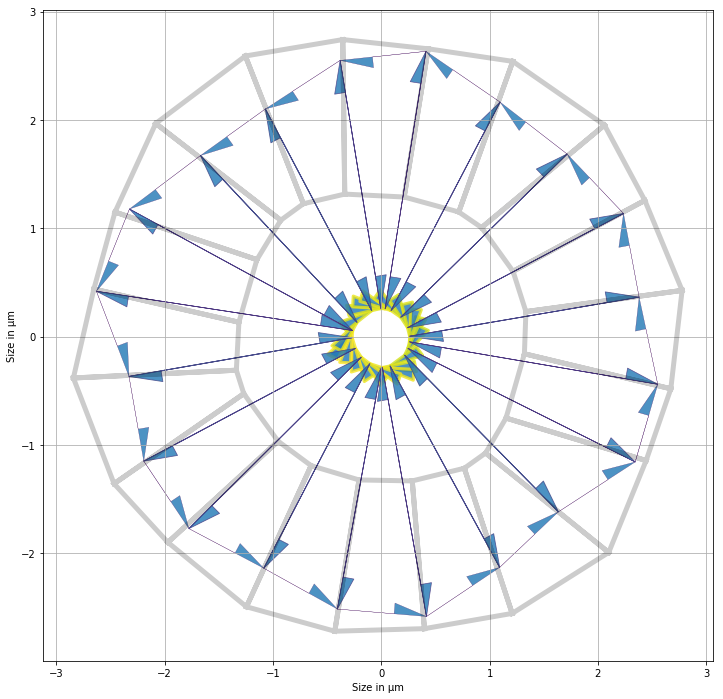

In [20]:
matrix = _coef_matrix(organo3, sup_param='pressions')
constant = _right_side(organo3, matrix)
mat_pressions, residuals = nnls(matrix, constant)
organo3_pressions = organo3.copy()
organo3_pressions.edge_df.loc[:, 'line_tension'] = prepare_tensions(organo3_pressions,
                                                                    mat_pressions[:3*organo3.Nf])
Solver.find_energy_min(organo3_pressions, geom, model)
print_tensions(organo3_pressions, organo3)
print('Apical tensions: ', mat_pressions[organo3.apical_edges],
      '\nBasal tensions: ', mat_pressions[organo3.basal_edges],
      '\nLateral tensions: ', mat_pressions[organo3.lateral_edges[:organo3.Nf]],
      '\nArea elasticity: ', mat_pressions[organo3.Nf*3:-1],
      '\nLumen area elasticity: ', mat_pressions[-1],
      '\nDistance to solution: ', np.linalg.norm(real_data[:organo3.Nf*3]-mat_pressions[:organo3.Nf*3]),
      '\nNNLS residuals: ', residuals)

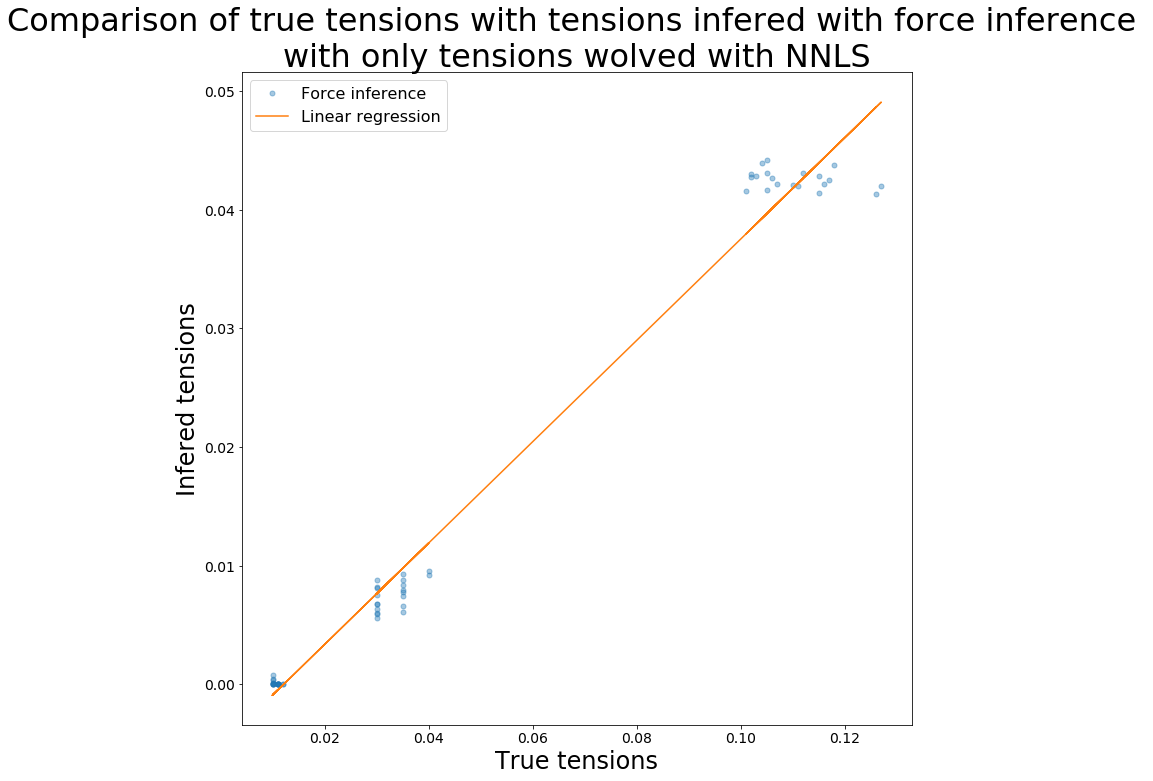

R value : 0.9916708713720854 
Standard error : 0.0020668596269718268


In [21]:
rendering_results(organo3, organo3.edge_df.line_tension[:3*organo3.Nf],
                  mat_pressions[:3*organo3.Nf],
                  'Comparison of true tensions with tensions infered with force inference \n' +
                  'with only tensions wolved with NNLS',
                  'True tensions', 'Infered tensions', ('Force inference', 'Linear regression'))

On conserve la symétrie mais on n'obtient pas le résultat attendu.

Remarque : les relations entre les lignes de A sont conservées avec les coefficients des pressions

In [22]:
matrix[1]+matrix[2]+matrix[3]+matrix[4]+matrix[5]

array([ 0.27517678,  0.        ,  0.        ,  0.        ,  0.        ,
       -0.95833594,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.95697717,  0.77794151,  0.31318774,  0.08226434,
       -0.15817158,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.19604961,  0.45886563,  0.66994286,  0.68182122,
        0.69816607,  0.        ,  0.        ,  0.        ,  0.  

In [23]:
-matrix[0]

array([ 0.27517678, -0.        , -0.        , -0.        , -0.        ,
       -0.        , -0.        , -0.        , -0.        , -0.        ,
       -0.        , -0.        , -0.        , -0.        , -0.        ,
       -0.        , -0.        , -0.        , -0.        , -0.03546277,
       -0.        , -0.        , -0.        , -0.        , -0.        ,
       -0.        , -0.        , -0.        , -0.        , -0.        ,
       -0.        , -0.        , -0.        , -0.        , -0.        ,
       -0.        , -0.        , -0.        , -0.        , -0.        ,
       -0.97259224, -0.        , -0.        , -0.        , -0.        ,
       -0.        , -0.        , -0.        , -0.        , -0.        ,
       -0.        , -0.        , -0.        , -0.        , -0.        ,
       -0.        , -0.        , -0.        , -0.        , -0.        ,
       -0.16152745, -0.        , -0.        , -0.        , -0.        ,
       -0.        , -0.        , -0.        , -0.        , -0.  

In [24]:
matrix[7]+matrix[8]+matrix[9]+matrix[10]+matrix[11]

array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.80378719,  0.        ,  0.        ,  0.        ,
        0.        ,  0.51804212,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        , -0.7366982 , -0.82162637, -0.99886143,
       -0.97476504, -0.94812925,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.46677886,  0.41544092,  0.03

In [25]:
-matrix[6]

array([-0.        , -0.        , -0.        , -0.        , -0.        ,
       -0.95833594,  0.80378719, -0.        , -0.        , -0.        ,
       -0.        , -0.        , -0.        , -0.        , -0.        ,
       -0.        , -0.        , -0.        , -0.        , -0.        ,
       -0.        , -0.        , -0.        , -0.        , -0.        ,
       -0.        , -0.        , -0.        , -0.        , -0.        ,
       -0.        , -0.        , -0.        , -0.        , -0.        ,
       -0.        , -0.        , -0.        , -0.        , -0.        ,
       -0.        , -0.        , -0.        , -0.        , -0.        ,
       -0.        ,  0.41643447, -0.        , -0.        , -0.        ,
       -0.        , -0.        , -0.        , -0.        , -0.        ,
       -0.        , -0.        , -0.        , -0.        , -0.        ,
       -0.        , -0.        , -0.        , -0.        , -0.        ,
       -0.        , -0.65127133, -0.        , -0.        , -0.  